In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cvxpy as cp

In [2]:
df_info = pd.read_csv('selected_esg_scores.csv') 
df_price = pd.read_csv('yahoo_all_stocks_10y_merged.csv') 
df_price['Date'] = pd.to_datetime(df_price['Date']) 
df_price = df_price.set_index('Date', inplace=False) 
# Ensure tickers exist 
tickers = df_info['Ticker'].dropna().unique().tolist()
missing = [t for t in tickers if t not in df_price.columns] 
if missing: 
    print("Missing tickers:", missing) 
    tickers = [t for t in tickers if t in df_price.columns] 
    
df_price = df_price[tickers].astype(float) 
df_return = np.log(df_price / df_price.shift(1)).dropna() 
df_return = df_return[tickers] 
df_cov = df_return.cov() 

display(df_info) 
display(df_price) 
display(df_return)
display(df_cov)

,Ticker,Category,ESG_Score
0,A,Health Care,13.64
1,AAL,Industrials,26.35
2,AAPL,Information Technology,17.22
3,ABBV,Health Care,29.93
4,ABT,Health Care,24.83
...,...,...,...
413,XOM,Energy,41.60
414,XYL,Industrials,18.13
415,YUM,Consumer Discretionary,20.10
416,ZBH,Health Care,26.02


,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WRB,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-19,34.346901,37.136383,21.793835,36.370693,33.530148,21.157492,86.559952,89.180000,40.530121,22.641352,...,11.601074,95.906914,17.242619,52.054638,27.328983,49.301327,29.154743,41.293980,88.826553,40.017273
2016-01-20,34.402287,37.327522,21.823139,37.799332,33.140358,20.567934,84.579094,87.940002,41.506676,23.220181,...,11.417117,94.968513,16.653643,49.589684,26.895655,47.223434,29.013226,40.825623,87.967278,40.573200
2016-01-21,34.374588,38.025143,21.712660,38.599636,32.742268,20.599632,83.921677,88.000000,41.465637,23.687708,...,11.414761,95.576721,16.924438,49.897804,26.535767,47.817116,29.393576,41.408073,87.877769,39.915356
2016-01-22,35.067066,38.378719,22.867058,38.910500,33.198402,20.701061,87.294235,89.629997,42.163155,24.659849,...,11.601074,97.271034,17.208763,52.089855,26.903004,49.411011,30.101215,41.420082,88.745995,40.211861
2016-01-25,34.725452,37.155495,22.420633,38.791447,32.891548,20.932446,86.875877,86.769997,41.892349,24.066174,...,11.308632,95.680992,16.592714,53.700890,26.829559,47.739681,29.844702,40.465347,88.665451,40.026539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-12,147.990005,16.000000,260.250000,218.283737,124.011818,93.239998,280.959991,327.649994,293.859985,62.200001,...,68.709999,329.450012,25.750000,116.839996,74.000000,124.029999,139.080002,156.919998,91.449997,125.320000
2026-01-13,146.320007,15.350000,261.049988,218.988083,123.673531,90.769997,276.799988,309.929993,296.209991,63.380001,...,68.000000,327.420013,25.450001,116.400002,74.940002,126.540001,140.110001,156.360001,88.339996,124.620003
2026-01-14,145.919998,15.140000,259.959991,220.118973,124.370003,91.290001,288.540009,304.440002,297.989990,64.599998,...,69.180000,328.190002,26.620001,116.879997,76.199997,130.199997,140.089996,157.130005,89.239998,125.839996


,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WRB,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2016-07-06,0.016324,-0.020252,0.005669,0.023147,0.034637,-0.002118,0.003707,0.004739,0.001804,0.004044,...,0.001701,0.011194,0.014042,0.009272,0.001324,0.011438,0.016368,0.013516,0.015141,0.012344
2016-07-07,-0.001125,0.036368,0.004283,0.000946,0.012897,-0.002264,-0.007249,-0.000420,0.008797,0.000000,...,-0.003575,-0.003450,0.000664,-0.010845,-0.022533,-0.012083,0.001096,0.001662,0.001969,-0.008352
2016-07-08,0.023583,0.021535,0.007684,0.011443,0.012733,0.002547,0.021159,0.017194,0.031492,0.031778,...,0.009337,0.004970,0.017432,0.008841,0.006073,0.006220,0.016950,0.017052,0.023248,0.016842
2016-07-11,-0.001760,0.036605,0.003098,0.002957,0.005475,-0.000283,0.003036,0.003610,0.008794,-0.007387,...,0.006568,0.003671,0.018415,0.047330,-0.004045,0.003735,0.012420,0.007898,0.001520,-0.004339
2016-07-12,0.024585,0.106451,0.004527,0.017713,0.008275,-0.003965,0.008967,0.004109,0.012624,0.003008,...,-0.002857,0.013296,0.019338,0.025185,-0.020704,0.011227,0.002763,-0.002432,0.003034,0.011939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-20,0.004560,-0.007326,-0.008639,-0.014967,-0.017432,0.007757,-0.001204,-0.018113,-0.030610,-0.006202,...,0.007923,-0.007877,0.000936,-0.010023,-0.002262,-0.002816,-0.006787,0.005983,-0.004257,-0.010216
2025-11-21,0.041787,0.050190,0.019490,0.029332,0.032850,0.006293,0.044909,0.037045,0.031127,0.013047,...,0.010296,0.000540,0.019004,0.020783,0.002262,0.000513,0.016881,0.024952,0.034321,0.051871
2025-11-24,0.015418,0.017713,0.016186,-0.029071,-0.007207,-0.005640,-0.033224,-0.016985,0.030020,0.000341,...,-0.007325,0.007809,-0.012474,0.029981,0.007378,-0.009526,0.010205,-0.012498,0.014432,0.006614


,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WRB,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZTS
A,0.000304,0.000188,0.000153,0.000105,0.000135,0.000109,0.000153,0.000181,0.000193,0.000100,...,0.000094,0.000103,0.000172,0.000178,0.000067,0.000096,0.000159,0.000097,0.000128,0.000160
AAL,0.000188,0.001092,0.000195,0.000085,0.000099,0.000209,0.000187,0.000179,0.000269,0.000171,...,0.000168,0.000147,0.000298,0.000485,0.000040,0.000199,0.000244,0.000155,0.000207,0.000145
AAPL,0.000153,0.000195,0.000339,0.000085,0.000117,0.000108,0.000162,0.000230,0.000219,0.000096,...,0.000090,0.000103,0.000171,0.000205,0.000073,0.000099,0.000146,0.000102,0.000116,0.000146
ABBV,0.000105,0.000085,0.000085,0.000268,0.000104,0.000091,0.000089,0.000093,0.000092,0.000072,...,0.000081,0.000075,0.000108,0.000094,0.000059,0.000085,0.000086,0.000068,0.000098,0.000101
ABT,0.000135,0.000099,0.000117,0.000104,0.000218,0.000097,0.000117,0.000136,0.000123,0.000080,...,0.000090,0.000095,0.000128,0.000091,0.000083,0.000063,0.000113,0.000084,0.000117,0.000131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XOM,0.000096,0.000199,0.000099,0.000085,0.000063,0.000140,0.000101,0.000078,0.000133,0.000150,...,0.000123,0.000086,0.000176,0.000223,0.000059,0.000317,0.000127,0.000089,0.000122,0.000077
XYL,0.000159,0.000244,0.000146,0.000086,0.000113,0.000152,0.000150,0.000151,0.000189,0.000117,...,0.000127,0.000124,0.000199,0.000209,0.000081,0.000127,0.000297,0.000112,0.000131,0.000130
YUM,0.000097,0.000155,0.000102,0.000068,0.000084,0.000113,0.000107,0.000106,0.000117,0.000083,...,0.000097,0.000095,0.000147,0.000158,0.000073,0.000089,0.000112,0.000203,0.000113,0.000105
ZBH,0.000128,0.000207,0.000116,0.000098,0.000117,0.000130,0.000124,0.000117,0.000143,0.000111,...,0.000110,0.000102,0.000171,0.000208,0.000066,0.000122,0.000131,0.000113,0.000325,0.000119


In [3]:
# Filter df_info to only those tickers we have returns for
df_info = df_info[df_info["Ticker"].isin(df_return.columns)].copy()

# Annualized return (log returns)
mu = df_return.mean() * 252

# Annualized volatility
sigma = df_return.std() * np.sqrt(252)

# Sharpe ratio (risk-free = 0)
sharpe = mu / sigma.replace(0, np.nan)

df_metrics = pd.DataFrame({
    "Ticker": df_return.columns,
    "Return": mu.values,
    "Volatility": sigma.values
})

# Merge with ESG info
df_topsis = df_info.merge(df_metrics, on="Ticker")


In [4]:
# refer here
def topsis(df, weights, types):
    norm = df / np.sqrt((df**2).sum())

    weighted = norm * weights

    ideal_best = np.max(weighted, axis=0) * (types == 1) + np.min(weighted, axis=0) * (types == -1)
    ideal_worst = np.min(weighted, axis=0) * (types == 1) + np.max(weighted, axis=0) * (types == -1)

    dist_best = np.sqrt(((weighted - ideal_best)**2).sum(axis=1))
    dist_worst = np.sqrt(((weighted - ideal_worst)**2).sum(axis=1))

    return dist_worst / (dist_best + dist_worst + 1e-12)


criteria = df_topsis[["ESG_Score", "Return", "Volatility"]].astype(float)

weights = np.array([0.4, 0.35, 0.25])
weights = weights / weights.sum()

types = np.array([1, 1, -1])

df_topsis["TOPSIS_score"] = topsis(criteria, weights, types)

# Choose top N
# top_n = 30
# selected_tickers = df_topsis.sort_values("TOPSIS_score", ascending=False).head(top_n)["Ticker"].tolist()

selected_tickers = df_topsis[df_topsis["TOPSIS_score"] > 0.5]["Ticker"].tolist()

df_info_sel = df_info[df_info["Ticker"].isin(selected_tickers)].copy()

df_return_sel = df_return[selected_tickers]
df_cov_sel = df_return_sel.cov()
mu_sel = df_return_sel.mean() * 252


In [5]:
selected_tickers

['AAPL',
 'ABBV',
 'AMAT',
 'AMZN',
 'ANET',
 'APH',
 'AVGO',
 'AXP',
 'BX',
 'CAT',
 'CDNS',
 'COST',
 'CTAS',
 'DE',
 'ETN',
 'FTNT',
 'GOOGL',
 'GS',
 'HCA',
 'IDXX',
 'ISRG',
 'JPM',
 'KLAC',
 'LLY',
 'LRCX',
 'META',
 'MPC',
 'MS',
 'MSCI',
 'MSFT',
 'MU',
 'NFLX',
 'NOW',
 'NRG',
 'NVDA',
 'PANW',
 'PGR',
 'PH',
 'PHM',
 'PWR',
 'RJF',
 'STLD',
 'STX',
 'TDG',
 'TER',
 'TRGP',
 'TSLA',
 'TT',
 'URI']

In [6]:
df_topsis.sort_values(by=['TOPSIS_score'], ascending=False)

,Ticker,Category,ESG_Score,Return,Volatility,TOPSIS_score
288,NVDA,Information Technology,13.59,0.537688,0.502853,0.758576
38,AVGO,Information Technology,19.98,0.376560,0.388987,0.699430
323,PWR,Industrials,36.91,0.321285,0.331679,0.698296
377,TSLA,Consumer Discretionary,25.23,0.362220,0.598958,0.680822
29,ANET,Information Technology,16.67,0.370072,0.444309,0.672495
...,...,...,...,...,...,...
226,KMX,Consumer Discretionary,12.10,-0.023809,0.409473,0.190817
345,SLB,Energy,20.28,-0.054904,0.409986,0.189934
302,PCG,Utilities,30.38,-0.144136,0.623421,0.187809
273,NCLH,Consumer Discretionary,25.94,-0.084534,0.628037,0.182065


In [7]:
# --- INPUTS (after TOPSIS selection) ---
n_assets = len(selected_tickers)
ones_vec = np.ones(n_assets)

# Annualized return of selected tickers
mu = mu_sel.values

# Covariance matrix of selected tickers (annualized)
Sigma = df_cov_sel.values * 252
Sigma = 0.5 * (Sigma + Sigma.T)

# Add tiny noise if singular
Sigma += np.eye(n_assets) * 1e-6

Sigma_inv = np.linalg.inv(Sigma)

# ESG & Sector info for selected tickers
esg = df_info_sel["ESG_Score"].astype(int).values
sectors = df_info_sel["Category"].tolist()
unique_sectors = sorted(set(sectors))

# --- Markowitz parameters ---
A = ones_vec @ Sigma_inv @ mu
B = mu.T @ Sigma_inv @ mu
C = ones_vec @ Sigma_inv @ ones_vec
D = B * C - A**2

g = (B * Sigma_inv @ ones_vec - A * Sigma_inv @ mu) / D
h = (C * Sigma_inv @ mu - A * Sigma_inv @ ones_vec) / D

w_min = Sigma_inv @ ones_vec / C
r_min = w_min @ mu

print("Number of selected tickers:", len(selected_tickers))
print("Minimum variance return:", r_min)
print("Minimum variance weights:\n", w_min)


Number of selected tickers: 49
Minimum variance return: 0.19712500263170962
Minimum variance weights:
 [ 0.0062223   0.14605228 -0.04454538  0.05605611 -0.0188972   0.12825523
  0.00372519 -0.04086219 -0.05413354  0.09184501  0.0249407   0.24717607
  0.01813198  0.06178472  0.02971609 -0.0053058   0.07509951  0.01673161
  0.03116045  0.02001479 -0.0475587   0.12910282  0.00166723  0.07051542
 -0.0563307  -0.00331344  0.00581461 -0.06705027  0.00211855  0.01622631
 -0.00074083  0.02300187 -0.03111386  0.02347764 -0.05484818  0.05765953
  0.14628104 -0.10195519  0.02898432  0.03526434 -0.00750389 -0.00601253
  0.0366729   0.03126002  0.01608695 -0.0150478  -0.00292709  0.05830509
 -0.08120409]


In [8]:
# --- Use TOPSIS-selected data ---
Sigma_np = df_cov_sel.values * 252          # annualized covariance
mu_np = mu_sel.values                       # annualized return
n = len(mu_np)

frontier = []

# Optimization Variables and Parameter
w = cp.Variable(n)
target_return_param = cp.Parameter()

# Objective: minimize portfolio variance
prob_obj = cp.Minimize(cp.quad_form(w, Sigma_np))

# Constraints
constraints = [
    cp.sum(w) == 1,
    w @ mu_np == target_return_param,
    w >= 0.0001,   # long-only + avoids tiny negative weights
    w <= 1
]

prob = cp.Problem(prob_obj, constraints)

# Build frontier
for tr in tqdm(np.linspace(mu_np.min(), mu_np.max(), 100), desc="Building frontier"):
    target_return_param.value = tr
    
    try:
        prob.solve(solver=cp.OSQP, warm_start=True)
        
        if prob.status == cp.OPTIMAL:
            w_val = w.value
            port_return = float(w_val @ mu_np)
            port_var = float(cp.quad_form(w_val, Sigma_np).value)
            port_std = np.sqrt(port_var)

            frontier.append({
                "target_return": tr,
                "achieved_return": port_return,
                "variance": port_var,
                "stdev": port_std,
                "weights": w_val
            })
    except Exception:
        continue

frontier_df = pd.DataFrame(frontier)


Building frontier:   0%|          | 0/100 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Building frontier: 100%|██████████| 100/100 [00:00<00:00, 642.34it/s]


In [9]:
frontier_df['weights']

0     [0.00010097601423548848, 0.5500562014949575, 0...
1     [0.00010164831446197893, 0.471113093318517, 0....
2     [0.00010233553916155286, 0.4003251583553865, 0...
3     [0.00010263016111584146, 0.3512635522141726, 0...
4     [0.00010411007574916342, 0.3059381867316644, 0...
                            ...                        
93    [9.889430891061693e-05, 9.870138421001713e-05,...
94    [9.88943088981167e-05, 9.870138416440884e-05, ...
95    [9.889430891713974e-05, 9.870138415519353e-05,...
96    [9.889430897900428e-05, 9.87013841879592e-05, ...
97    [9.889430891946333e-05, 9.870138416256315e-05,...
Name: weights, Length: 98, dtype: object

In [10]:
import numpy as np
import pandas as pd
from tqdm import tqdm

# ---------------------------
# 1. Inputs from your pipeline
# ---------------------------
mu = mu_sel.values                               # annualized return vector
Sigma = df_cov_sel.values * 252                  # annualized covariance matrix
n_assets = len(mu)

# If covariance is singular, add tiny noise
Sigma += np.eye(n_assets) * 1e-6

# ---------------------------
# 2. Analytical Frontier
# ---------------------------
inv_sigma = np.linalg.pinv(Sigma)
ones = np.ones(n_assets)

A = ones @ inv_sigma @ mu
B = mu @ inv_sigma @ mu
C = ones @ inv_sigma @ ones
D = B * C - A**2

m = np.linspace(mu.min(), mu.max(), 100)
Sigma_m = np.sqrt((C / D) * (m - A / C) ** 2 + 1 / C)

# ---------------------------
# 3. Global Random Portfolios
# ---------------------------
num_port_global = 100000
alpha = 0.0005

weights_global = np.random.dirichlet(np.full(n_assets, alpha), num_port_global)

port_returns_1 = weights_global @ mu
port_vars_1 = np.einsum('ij,jk,ik->i', weights_global, Sigma, weights_global)
port_stdevs_1 = np.sqrt(port_vars_1)

port_df_1 = pd.DataFrame({
    'Volatility': port_stdevs_1,
    'Return': port_returns_1
})

# ---------------------------
# 4. Frontier-Focused Sampling (Stratified)
# ---------------------------
# Ensure frontier_df exists
W_front = np.array(frontier_df["weights"].tolist())
eps = 1e-7

num_port_strat = 5000
n_bins = len(frontier_df)
n_per_bin = num_port_strat // n_bins

kappa_min, kappa_max = 1, 100000.0
n_kappa_levels = 20

kappa_vals = np.geomspace(kappa_min, kappa_max, n_kappa_levels)
kappa_wts = 1.0 / (kappa_vals**1 + 1e-12)
kappa_wts /= kappa_wts.sum()

weights_list = []

for i in range(n_bins):
    sizes = np.floor(n_per_bin * kappa_wts).astype(int)
    leftover = n_per_bin - sizes.sum()
    if leftover > 0:
        sizes[:leftover] += 1

    for kappa, sz in zip(kappa_vals, sizes):
        if sz > 0:
            alphas_i = kappa * (W_front[i] + eps)
            weights_list.append(np.random.dirichlet(alphas_i, sz))

weights_strat = np.vstack(weights_list)

port_returns_2 = weights_strat @ mu
port_vars_2 = np.einsum('ij,jk,ik->i', weights_strat, Sigma, weights_strat)
port_stdevs_2 = np.sqrt(port_vars_2)

port_df_2 = pd.DataFrame({
    'Volatility': port_stdevs_2,
    'Return': port_returns_2
})

# ---------------------------
# 5. Combine
# ---------------------------
port_df = pd.concat([port_df_1, port_df_2], ignore_index=True)


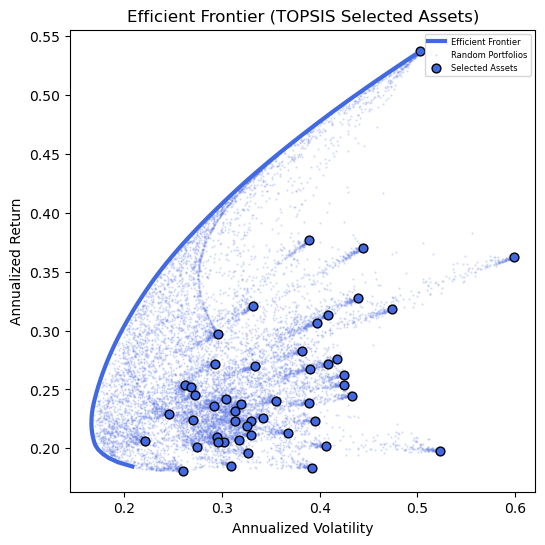

In [11]:
plt.figure(figsize=(6, 6))

# Efficient Frontier from CVXPY
plt.plot(
    frontier_df["stdev"],
    frontier_df["achieved_return"],
    color='royalblue',
    linewidth=3,
    label="Efficient Frontier"
)

# Global + Stratified random portfolios
plt.scatter(
    port_df['Volatility'],
    port_df['Return'],
    s=0.5,
    c='#6881E7',
    alpha=0.2,
    label="Random Portfolios"
)

# Individual selected assets (tickers)
asset_returns = mu_sel.values
asset_stdevs = df_return_sel.std(axis=0) * np.sqrt(252)

plt.scatter(
    asset_stdevs,
    asset_returns,
    facecolors='royalblue',
    edgecolors='k',
    linewidths=1,
    s=40,
    label="Selected Assets"
)

plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.title("Efficient Frontier (TOPSIS Selected Assets)")
plt.legend(loc="best", fontsize=6)

plt.savefig('TOPSIS/Portfolio_Frontier.png', dpi=144, transparent=True)
plt.show()


In [12]:
print(selected_tickers)

['AAPL', 'ABBV', 'AMAT', 'AMZN', 'ANET', 'APH', 'AVGO', 'AXP', 'BX', 'CAT', 'CDNS', 'COST', 'CTAS', 'DE', 'ETN', 'FTNT', 'GOOGL', 'GS', 'HCA', 'IDXX', 'ISRG', 'JPM', 'KLAC', 'LLY', 'LRCX', 'META', 'MPC', 'MS', 'MSCI', 'MSFT', 'MU', 'NFLX', 'NOW', 'NRG', 'NVDA', 'PANW', 'PGR', 'PH', 'PHM', 'PWR', 'RJF', 'STLD', 'STX', 'TDG', 'TER', 'TRGP', 'TSLA', 'TT', 'URI']


In [13]:
## MIQP (actually continuous relaxation)
esg_min = 30
max_w_per_asset = 0.20
min_w_if_selected = 0.0001
max_w_per_sector = 0.25
min_n_assets = 5

# Align info
df_info_sel = df_info_sel.set_index("Ticker").loc[selected_tickers].reset_index()

esg_sel = df_info_sel["ESG_Score"].values
sectors_sel = df_info_sel["Category"].tolist()
unique_sectors_sel = sorted(set(sectors_sel))

In [14]:
# Data prep
mu_np = np.array(mu_sel).flatten()
Sigma_np = np.array(df_cov_sel) * 252
Sigma_np = (Sigma_np + Sigma_np.T) / 2

esg_np = np.array(esg_sel).flatten()
n_assets = len(mu_np)

frontier_esg = []
grid = np.linspace(mu_np.min(), mu_np.max(), 30)

sector_masks = [
    np.array([1 if sct == sec else 0 for sct in sectors_sel])
    for sec in unique_sectors_sel
]

for tr in tqdm(grid, desc="Building ESG frontier"):

    w = cp.Variable(n_assets)
    y = cp.Variable(n_assets)  # continuous relaxation

    risk = cp.quad_form(w, cp.psd_wrap(Sigma_np))

    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        mu_np @ w >= tr,            # <-- use >= not ==
        esg_np @ w >= esg_min,

        # selection constraints (continuous)
        y >= 0,
        y <= 1,
        cp.sum(y) >= min_n_assets,
        w <= y,
        w >= min_w_if_selected * y,

        # max weight per asset
        w <= max_w_per_asset
    ]

    for mask in sector_masks:
        constraints.append(mask @ w <= max_w_per_sector)

    objective = cp.Minimize(risk + 0.001 * cp.sum(y))

    prob = cp.Problem(objective, constraints)

    try:
        prob.solve(solver=cp.OSQP, warm_start=True)

        if prob.status == cp.OPTIMAL:
            w_val = np.array(w.value).flatten()
            w_val[w_val < 1e-6] = 0

            p_ret = float(mu_np @ w_val)
            p_var = float(w_val @ Sigma_np @ w_val)

            frontier_esg.append({
                "target_return": tr,
                "achieved_return": p_ret,
                "variance": p_var,
                "stdev": np.sqrt(p_var),
                "weights": w_val
            })
    except Exception as e:
        print(f"Solver Error: {e}")
        continue

frontier_esg_df = pd.DataFrame(frontier_esg)

Building ESG frontier: 100%|██████████| 30/30 [00:00<00:00, 112.23it/s]


In [15]:
frontier_esg_df['weights']

0     [0.0, 0.2000011435607025, 0.0, 0.0809336955072...
1     [0.0, 0.20000115823515804, 0.0, 0.080933750803...
2     [0.0, 0.200001185990086, 0.0, 0.08093385247895...
3     [0.0, 0.20000126399044324, 0.0, 0.080934139484...
4     [1.7074582961821723e-06, 0.18219445704585036, ...
5     [4.351285095610067e-06, 0.1359761667015356, 0....
6     [5.424838718811461e-06, 0.09953931921974114, 0...
7     [5.396671634001432e-06, 0.07828582891576581, 0...
8     [4.998216513511313e-06, 0.060738139934712485, ...
9     [0.0, 0.0499935638436844, 0.0, 0.0519782020952...
10    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
11    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: weights, dtype: object

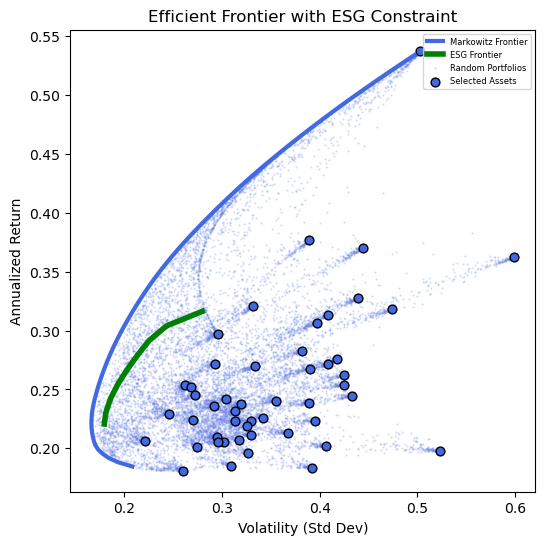

In [16]:
# --- asset stats for TOPSIS selected tickers ---
asset_returns = mu_sel.values
asset_stdevs = df_return_sel.std(axis=0) * np.sqrt(252)

plt.figure(figsize=(6, 6))

# efficient frontier without ESG
plt.plot(frontier_df["stdev"], frontier_df["achieved_return"],
         color='royalblue', linewidth=3, label="Markowitz Frontier")

# efficient frontier with ESG
plt.plot(frontier_esg_df["stdev"], frontier_esg_df["achieved_return"],
         color='green', linewidth=4, label="ESG Frontier")

# scatter of random portfolios
plt.scatter(port_df['Volatility'], port_df['Return'],
            s=0.5, c='#6881E7', alpha=0.2, label="Random Portfolios")

# scatter of individual assets (TOPSIS selected)
plt.scatter(asset_stdevs, asset_returns,
            facecolors='royalblue', edgecolors='k', linewidths=1, s=40,
            label="Selected Assets")

plt.legend(loc="best", fontsize=6)
plt.xlabel("Volatility (Std Dev)")
plt.ylabel("Annualized Return")
plt.title("Efficient Frontier with ESG Constraint")

plt.savefig('TOPSIS/Portfolio_Frontier_ESG.png', dpi=144, transparent=True)
plt.show()


In [17]:
## Brown Portfolio

In [18]:
esg_max = 30

In [19]:
# ---------------------------------------------------
# Brown / Low-ESG Efficient Frontier (Relaxed)
# ---------------------------------------------------

esg_max = 30                 # LOW ESG threshold (Brown)
max_w_per_asset = 0.20
min_w_if_selected = 0.0001
max_w_per_sector = 0.25
min_n_assets = 5

# --- DATA SETUP (TOPSIS-selected universe) ---
mu_np = mu_sel.values
Sigma_np = df_cov_sel.values * 252
Sigma_np = (Sigma_np + Sigma_np.T) / 2

esg_np = esg_sel
sectors = sectors_sel
unique_sectors = unique_sectors_sel

n_assets = len(mu_np)

# Safety: small diagonal ridge
Sigma_np += np.eye(n_assets) * 1e-6

# Precompute sector masks
sector_masks = [
    np.array([1 if sct == sec else 0 for sct in sectors])
    for sec in unique_sectors
]

frontier_brown = []

# Target return grid
grid = np.linspace(mu_np.min(), mu_np.max() * 0.9, 30)

# --- Optimization Loop ---
for tr in tqdm(grid, desc="Building Brown (Low-ESG) Frontier"):

    w = cp.Variable(n_assets)
    y = cp.Variable(n_assets)   # continuous relaxation

    risk = cp.quad_form(w, cp.psd_wrap(Sigma_np))

    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        mu_np @ w >= tr,
        esg_np @ w <= esg_max,          # LOW ESG constraint

        # selection constraints
        y >= 0,
        y <= 1,
        cp.sum(y) >= min_n_assets,
        w <= y,
        w >= min_w_if_selected * y,

        # max per asset
        w <= max_w_per_asset
    ]

    # sector caps
    for mask in sector_masks:
        constraints.append(mask @ w <= max_w_per_sector)

    objective = cp.Minimize(risk + 0.001 * cp.sum(y))

    prob = cp.Problem(objective, constraints)

    try:
        prob.solve(solver=cp.OSQP, warm_start=True)

        if prob.status == cp.OPTIMAL:
            w_val = np.array(w.value).flatten()
            w_val[w_val < 1e-6] = 0

            p_ret = float(mu_np @ w_val)
            p_var = float(w_val @ Sigma_np @ w_val)

            frontier_brown.append({
                "target_return": tr,
                "achieved_return": p_ret,
                "variance": p_var,
                "stdev": np.sqrt(p_var),
                "weights": w_val
            })

    except Exception as e:
        print(f"Solver error at tr={tr:.4f}: {e}")
        continue

frontier_brown_df = pd.DataFrame(frontier_brown)


Building Brown (Low-ESG) Frontier: 100%|██████████| 30/30 [00:00<00:00, 133.73it/s]


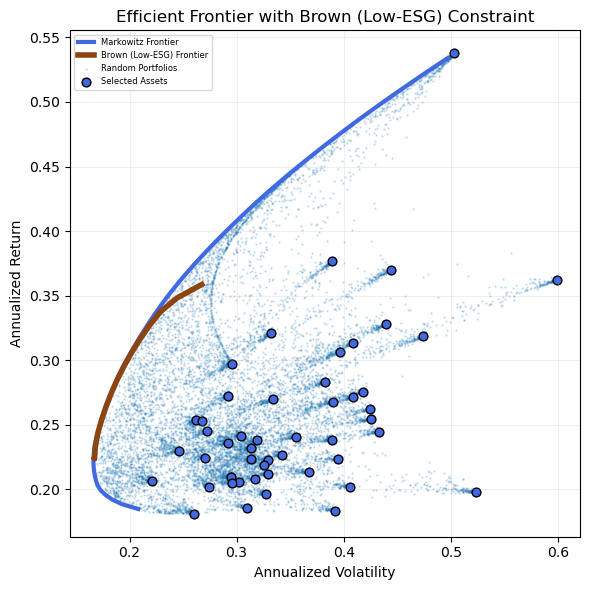

In [20]:
plt.figure(figsize=(6, 6))

# --- Markowitz frontier (no ESG) ---
plt.plot(
    frontier_df["stdev"],
    frontier_df["achieved_return"],
    color="royalblue",
    linewidth=3,
    label="Markowitz Frontier"
)

# --- Brown (Low-ESG) frontier ---
plt.plot(
    frontier_brown_df["stdev"],
    frontier_brown_df["achieved_return"],
    color="saddlebrown",
    linewidth=4,
    label="Brown (Low-ESG) Frontier"
)

# --- Random portfolios ---
plt.scatter(
    port_df["Volatility"],
    port_df["Return"],
    s=0.5,
    alpha=0.2,
    label="Random Portfolios"
)

# --- Individual assets (TOPSIS-selected) ---
plt.scatter(
    asset_stdevs,
    asset_returns,
    facecolors="royalblue",
    edgecolors="k",
    linewidths=1,
    s=40,
    label="Selected Assets"
)

plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.title("Efficient Frontier with Brown (Low-ESG) Constraint")
plt.legend(loc="best", fontsize=6)
plt.grid(alpha=0.2)

plt.tight_layout()
plt.savefig("TOPSIS/Portfolio_Frontier_ESG_Brown.png", dpi=144, transparent=True)
plt.show()


In [21]:
# ---------------------------------------------------
# Sort ESG frontiers for correct plotting
# ---------------------------------------------------

frontier_esg_df = (
    frontier_esg_df
    .dropna()
    .sort_values(by="achieved_return", ascending=True)
    .reset_index(drop=True)
)

frontier_brown_df = (
    frontier_brown_df
    .dropna()
    .sort_values(by="achieved_return", ascending=True)
    .reset_index(drop=True)
)


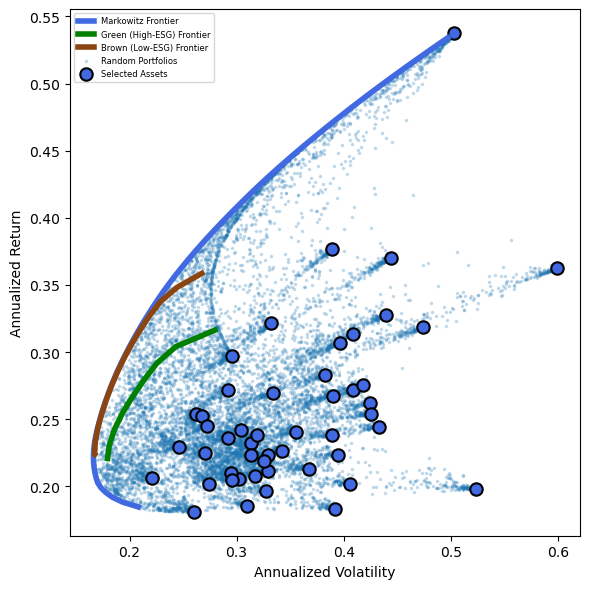

In [ ]:
# plt.figure(figsize=(6, 6))

# # -------------------------------------------------
# # Efficient Frontiers (already sorted by return)
# # -------------------------------------------------
# plt.plot(
#     frontier_df["stdev"],
#     frontier_df["achieved_return"],
#     color="royalblue",
#     linewidth=4,
#     label="Markowitz Frontier"
# )

# plt.plot(
#     frontier_esg_df["stdev"],
#     frontier_esg_df["achieved_return"],
#     color="green",
#     linewidth=4,
#     label="Green (High-ESG) Frontier"
# )

# plt.plot(
#     frontier_brown_df["stdev"],
#     frontier_brown_df["achieved_return"],
#     color="saddlebrown",
#     linewidth=4,
#     label="Brown (Low-ESG) Frontier"
# )

# # -------------------------------------------------
# # Random Portfolios Cloud
# # -------------------------------------------------
# plt.scatter(
#     port_df["Volatility"],
#     port_df["Return"],
#     s=2.5,
#     alpha=0.2,
#     label="Random Portfolios"
# )

# # -------------------------------------------------
# # Individual Assets (TOPSIS-selected)
# # -------------------------------------------------
# plt.scatter(
#     asset_stdevs,
#     asset_returns,
#     facecolors="royalblue",
#     edgecolors="k",
#     linewidths=1.5,
#     s=80,
#     label="Selected Assets"
# )

# # -------------------------------------------------
# # Labels & Layout
# # -------------------------------------------------
# plt.xlabel("Annualized Volatility")
# plt.ylabel("Annualized Return")
# plt.legend(loc="best", fontsize=6)
# plt.tight_layout()

# plt.savefig(
#     "TOPSIS/Portfolio_Frontier_ESG_Brown_Zoom.png",
#     dpi=144,
#     transparent=True
# )

# plt.show()


In [23]:
## Benchmark

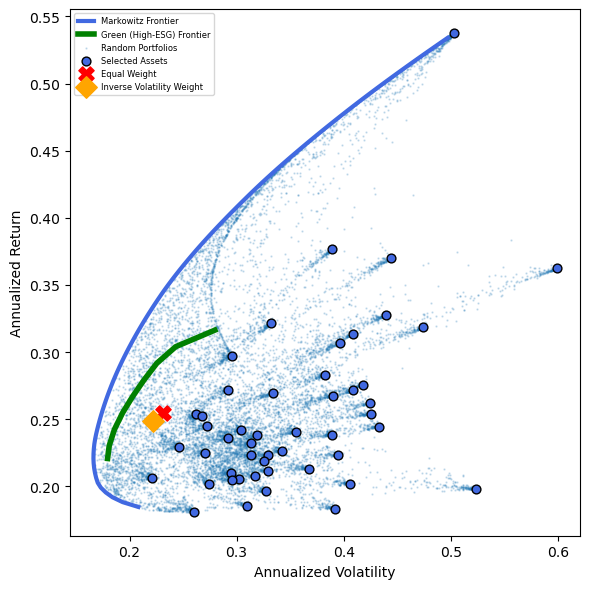

In [24]:
# -------------------------------------------------
# Benchmarks (TOPSIS-selected universe)
# -------------------------------------------------

# Equal-weight portfolio
n_assets = len(mu_sel)
w_ew = np.ones(n_assets) / n_assets
ret_ew = float(mu_sel.values @ w_ew)
vol_ew = float(np.sqrt(w_ew @ (df_cov_sel.values * 252) @ w_ew))

# Inverse-volatility-weighted portfolio
asset_vols = df_return_sel.std(axis=0).values * np.sqrt(252)
inv_vol = 1.0 / asset_vols
w_ivw = inv_vol / inv_vol.sum()

ret_ivw = float(mu_sel.values @ w_ivw)
vol_ivw = float(np.sqrt(w_ivw @ (df_cov_sel.values * 252) @ w_ivw))

# -------------------------------------------------
# Plot
# -------------------------------------------------
plt.figure(figsize=(6, 6))

# Efficient frontiers
plt.plot(
    frontier_df["stdev"],
    frontier_df["achieved_return"],
    color="royalblue",
    linewidth=3,
    label="Markowitz Frontier"
)

plt.plot(
    frontier_esg_df["stdev"],
    frontier_esg_df["achieved_return"],
    color="green",
    linewidth=4,
    label="Green (High-ESG) Frontier"
)

# Random portfolios cloud
plt.scatter(
    port_df["Volatility"],
    port_df["Return"],
    s=0.5,
    alpha=0.2,
    label="Random Portfolios"
)

# Individual assets
plt.scatter(
    asset_stdevs,
    asset_returns,
    facecolors="royalblue",
    edgecolors="k",
    linewidths=1,
    s=40,
    label="Selected Assets"
)

# Benchmarks
plt.scatter(
    vol_ew,
    ret_ew,
    c="red",
    marker="X",
    s=120,
    label="Equal Weight"
)

plt.scatter(
    vol_ivw,
    ret_ivw,
    c="orange",
    marker="D",
    s=120,
    label="Inverse Volatility Weight"
)

# Labels & layout
plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.legend(loc="best", fontsize=6)
plt.tight_layout()

plt.savefig(
    "TOPSIS/ESG_Frontier_vs_Benchmarks.png",
    dpi=144,
    transparent=True
)

plt.show()


In [25]:
## Output

In [26]:
def parse_weights(w):
    if isinstance(w, str):
        return np.fromstring(w.strip("[]"), sep=" ")
    elif isinstance(w, (list, np.ndarray)):
        return np.array(w, dtype=float)
    else:
        raise ValueError(f"Unexpected weights type: {type(w)}")

def expand_frontier(df_in, asset_cols, out_path):
    """
    Expands a frontier DataFrame by unpacking portfolio weights
    into individual asset columns.
    """
    # Extract weight matrix
    wmat = np.vstack(df_in["weights"].apply(parse_weights).to_numpy())

    # Safety check
    if wmat.shape[1] != len(asset_cols):
        raise ValueError(
            f"Weight dimension mismatch: "
            f"{wmat.shape[1]} weights vs {len(asset_cols)} asset columns"
        )

    # Build expanded DataFrame
    wdf = pd.DataFrame(wmat, columns=asset_cols, index=df_in.index)
    df_out = pd.concat([df_in.drop(columns=["weights"]), wdf], axis=1)

    # Save
    df_out.to_csv(out_path, index=False)
    return df_out

asset_cols = df_return_sel.columns.tolist()

frontier_expanded = expand_frontier(
    frontier_df,
    asset_cols,
    "TOPSIS/frontier_markowitz_expanded.csv"
)

frontier_esg_expanded = expand_frontier(
    frontier_esg_df,
    asset_cols,
    "TOPSIS/frontier_green_expanded.csv"
)

frontier_brown_expanded = expand_frontier(
    frontier_brown_df,
    asset_cols,
    "TOPSIS/frontier_brown_expanded.csv"
)


In [27]:
# -------------------------------------------------
# Export expanded frontiers (project-consistent)
# -------------------------------------------------

frontier_expanded.to_csv(
    "TOPSIS/frontier_markowitz_expanded.csv",
    index=False
)

frontier_esg_expanded.to_csv(
    "TOPSIS/frontier_green_expanded.csv",
    index=False
)

frontier_brown_expanded.to_csv(
    "TOPSIS/frontier_brown_expanded.csv",
    index=False
)


In [28]:
## Tangency Portfolio

In [29]:
# ============================================================
# Tangency Portfolios (Maximum Sharpe Ratio)
# ============================================================

rf = 0.00012 *252  # annualized risk-free rate (keep consistent)

asset_cols = df_return_sel.columns.tolist()
os.makedirs("TOPSIS/Tangency", exist_ok=True)

def scalarize(x):
    """Convert arrays/lists to a single scalar float."""
    arr = np.array(x).ravel()
    if arr.size == 0:
        return np.nan
    return float(arr[0])

def vectorize_weights(w):
    """Convert weights to 1D numpy array."""
    if isinstance(w, str):
        w = w.strip("[]")
        w = np.array(w.split(), dtype=float)
    else:
        w = np.array(w).ravel()
    return w.astype(float)

def compute_tangency(frontier_df, rf):
    df = frontier_df.copy()

    # Force scalar values
    df["stdev"] = pd.to_numeric(df["stdev"], errors="coerce")
    df["achieved_return"] = pd.to_numeric(df["achieved_return"], errors="coerce")

    # Compute Sharpe
    df["sharpe"] = (df["achieved_return"] - rf) / df["stdev"]

    # ONLY clean sharpe column (no replace on full df)
    df = df[np.isfinite(df["sharpe"])]

    idx = df["sharpe"].idxmax()

    w = vectorize_weights(df.loc[idx, "weights"])
    ret = float(df.loc[idx, "achieved_return"])
    vol = float(df.loc[idx, "stdev"])
    sharpe = float(df.loc[idx, "sharpe"])

    return w, ret, vol, sharpe


# ------------------------------------------------------------
# Tangency portfolios
# ------------------------------------------------------------
tan_w, tan_ret, tan_vol, tan_sharpe = compute_tangency(frontier_df, rf)
tan_w_esg, tan_ret_esg, tan_vol_esg, tan_sharpe_esg = compute_tangency(frontier_esg_df, rf)
tan_w_b, tan_ret_b, tan_vol_b, tan_sharpe_b = compute_tangency(frontier_brown_df, rf)

# ------------------------------------------------------------
# Export weights
# ------------------------------------------------------------
pd.DataFrame({"asset": asset_cols, "weight": tan_w}).to_csv(
    "TOPSIS/Tangency/tangency_markowitz_weights.csv", index=False)

pd.DataFrame({"asset": asset_cols, "weight": tan_w_esg}).to_csv(
    "TOPSIS/Tangency/tangency_green_weights.csv", index=False)

pd.DataFrame({"asset": asset_cols, "weight": tan_w_b}).to_csv(
    "TOPSIS/Tangency/tangency_brown_weights.csv", index=False)

# ------------------------------------------------------------
# Export summaries
# ------------------------------------------------------------
summary_df = pd.DataFrame([
    {"frontier": "markowitz", "rf": rf, "return": tan_ret, "volatility": tan_vol, "sharpe": tan_sharpe},
    {"frontier": "green",     "rf": rf, "return": tan_ret_esg, "volatility": tan_vol_esg, "sharpe": tan_sharpe_esg},
    {"frontier": "brown",     "rf": rf, "return": tan_ret_b, "volatility": tan_vol_b, "sharpe": tan_sharpe_b}
])

summary_df.to_csv("TOPSIS/Tangency/tangency_summary.csv", index=False)


In [30]:
import matplotlib.pyplot as plt

def plot_frontier(
    title,
    filename,
    frontiers,
    mc_df,
    asset_returns,
    asset_stdevs,
    rf,
    tangencies,
    benchmarks=None,
    xlim=None,
    ylim=None,
    figsize=(6,6)
):
    plt.figure(figsize=figsize)

    # Plot frontiers
    for f in frontiers:
        plt.plot(
            f["stdev"],
            f["achieved_return"],
            linewidth=f.get("lw", 3),
            color=f["color"],
            label=f["label"]
        )

    # MC portfolios
    plt.scatter(
        mc_df["Volatility"], mc_df["Return"],
        s=0.5, c='#6881E7', alpha=0.2, label="MC Portfolios"
    )

    # Assets
    plt.scatter(
        asset_stdevs, asset_returns,
        facecolors='royalblue', edgecolors='k',
        linewidths=1, s=40, label="Assets"
    )

    # Tangency points and CAL
    for t in tangencies:
        plt.scatter(
            t["vol"], t["ret"],
            c=t["color"], edgecolors='k', marker='*',
            s=t.get("size", 250), linewidths=2.5, label=t["label"]
        )
        plt.plot(
            [0, t["vol"]],
            [rf, t["ret"]],
            linestyle='--',
            color='gray',
            linewidth=2.5,
            label=f'CAL ({t["label"]})'
        )

    # Benchmarks
    if benchmarks:
        for b in benchmarks:
            plt.scatter(
                b["vol"], b["ret"],
                c=b["color"],
                marker=b["marker"],
                s=b["s"],
                label=b["label"]
            )

    plt.scatter(0, rf, facecolors='none', edgecolors='k', s=40,
                linewidths=2, label='Risk-Free Asset')

    plt.title(title)
    plt.xlabel("Volatility (Std Dev)")
    plt.ylabel("Return")
    plt.grid(True)

    if xlim:
        plt.xlim(*xlim)
    if ylim:
        plt.ylim(*ylim)

    plt.legend(loc='best', fontsize=8)
    plt.savefig(f"TOPSIS/{filename}", dpi=144, transparent=True)
    plt.show()


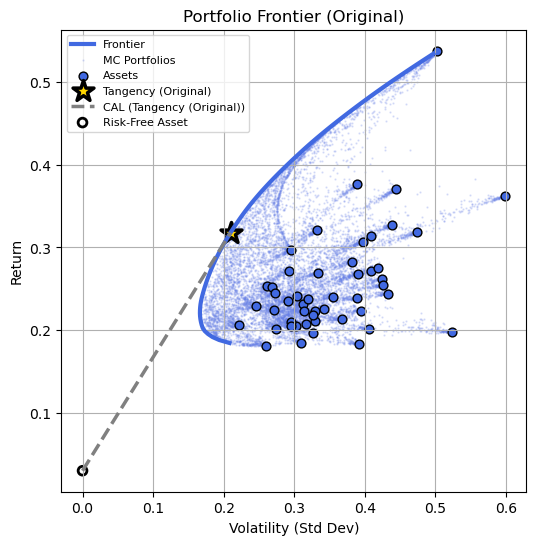

In [31]:
plot_frontier(
    title="Portfolio Frontier (Original)",
    filename="Portfolio_Frontier.png",
    frontiers=[
        {"stdev": frontier_df["stdev"], "achieved_return": frontier_df["achieved_return"],
         "color":"royalblue", "label":"Frontier"}
    ],
    mc_df=port_df,
    asset_returns=asset_returns,
    asset_stdevs=asset_stdevs,
    rf=rf,
    tangencies=[
        {"vol": tan_vol, "ret": tan_ret, "color":"gold", "label":"Tangency (Original)"}
    ]
)


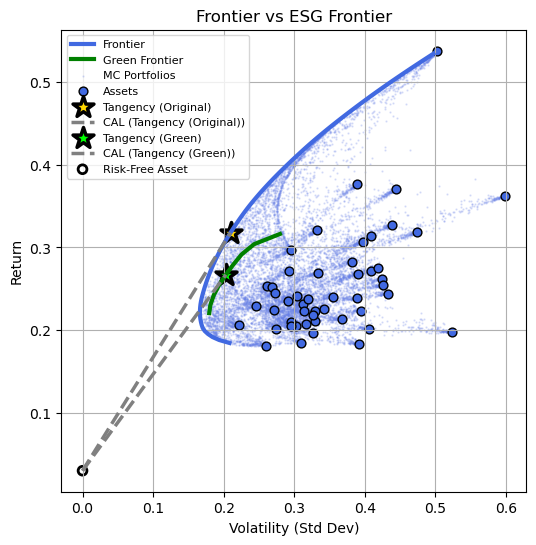

In [32]:
plot_frontier(
    title="Frontier vs ESG Frontier",
    filename="Portfolio_Frontier_ESG.png",
    frontiers=[
        {"stdev": frontier_df["stdev"], "achieved_return": frontier_df["achieved_return"],
         "color":"royalblue", "label":"Frontier"},
        {"stdev": frontier_esg_df["stdev"], "achieved_return": frontier_esg_df["achieved_return"],
         "color":"green", "label":"Green Frontier"}
    ],
    mc_df=port_df,
    asset_returns=asset_returns,
    asset_stdevs=asset_stdevs,
    rf=rf,
    tangencies=[
        {"vol": tan_vol, "ret": tan_ret, "color":"gold", "label":"Tangency (Original)"},
        {"vol": tan_vol_esg, "ret": tan_ret_esg, "color":"lime", "label":"Tangency (Green)"}
    ]
)


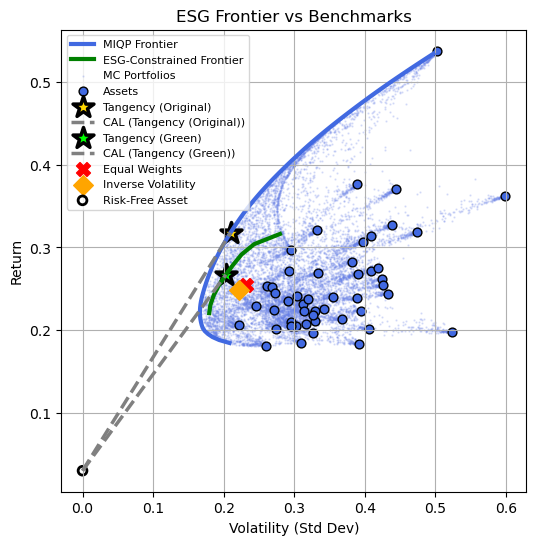

In [33]:
plot_frontier(
    title="ESG Frontier vs Benchmarks",
    filename="ESG_Frontier_vs_Benchmarks.png",
    frontiers=[
        {"stdev": frontier_df["stdev"], "achieved_return": frontier_df["achieved_return"],
         "color":"royalblue", "label":"MIQP Frontier"},
        {"stdev": frontier_esg_df["stdev"], "achieved_return": frontier_esg_df["achieved_return"],
         "color":"green", "label":"ESG-Constrained Frontier"}
    ],
    mc_df=port_df,
    asset_returns=asset_returns,
    asset_stdevs=asset_stdevs,
    rf=rf,
    tangencies=[
        {"vol": tan_vol, "ret": tan_ret, "color":"gold", "label":"Tangency (Original)"},
        {"vol": tan_vol_esg, "ret": tan_ret_esg, "color":"lime", "label":"Tangency (Green)"}
    ],
    benchmarks=[
        {"vol": vol_ew, "ret": ret_ew, "color":"red", "marker":"X", "s":100, "label":"Equal Weights"},
        {"vol": vol_ivw, "ret": ret_ivw, "color":"orange", "marker":"D", "s":100, "label":"Inverse Volatility"}
    ]
)


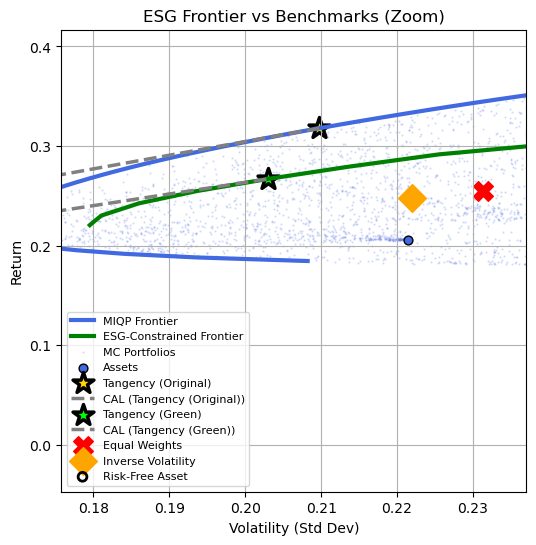

In [34]:
# -------------------------
# Zoom around tangency
# -------------------------
margin = 0.02  # increase if you want wider zoom

mask_blue  = (frontier_df["stdev"] >= tan_vol - margin) & (frontier_df["stdev"] <= tan_vol + margin)
mask_green = (frontier_esg_df["stdev"] >= tan_vol_esg - margin) & (frontier_esg_df["stdev"] <= tan_vol_esg + margin)

x_min = min(
    frontier_df.loc[mask_blue, "stdev"].min(),
    frontier_esg_df.loc[mask_green, "stdev"].min(),
    tan_vol,
    tan_vol_esg,
)

x_max = max(
    frontier_df.loc[mask_blue, "stdev"].max(),
    frontier_esg_df.loc[mask_green, "stdev"].max(),
    tan_vol,
    tan_vol_esg,
)

y_min = min(
    frontier_df.loc[mask_blue, "achieved_return"].min(),
    frontier_esg_df.loc[mask_green, "achieved_return"].min(),
    tan_ret,
    tan_ret_esg,
    rf
)

y_max = max(
    frontier_df.loc[mask_blue, "achieved_return"].max(),
    frontier_esg_df.loc[mask_green, "achieved_return"].max(),
    tan_ret,
    tan_ret_esg
)

# Add padding
pad_x = (x_max - x_min) * 0.25
pad_y = (y_max - y_min) * 0.25

xlim_zoom = (x_min - pad_x, x_max + pad_x)
ylim_zoom = (y_min - pad_y, y_max + pad_y)


# -------------------------
# Plot
# -------------------------
plot_frontier(
    title="ESG Frontier vs Benchmarks (Zoom)",
    filename="ESG_Frontier_vs_Benchmarks_Zoom.png",
    frontiers=[
        {"stdev": frontier_df["stdev"], "achieved_return": frontier_df["achieved_return"], "color":"royalblue", "label":"MIQP Frontier"},
        {"stdev": frontier_esg_df["stdev"], "achieved_return": frontier_esg_df["achieved_return"], "color":"green", "label":"ESG-Constrained Frontier"}
    ],
    mc_df=port_df,
    asset_returns=asset_returns,
    asset_stdevs=asset_stdevs,
    rf=rf,
    tangencies=[
        {"vol": tan_vol, "ret": tan_ret, "color":"gold", "label":"Tangency (Original)"},
        {"vol": tan_vol_esg, "ret": tan_ret_esg, "color":"lime", "label":"Tangency (Green)"}
    ],
    benchmarks=[
        {"vol": vol_ew, "ret": ret_ew, "color":"red", "marker":"X", "s":200, "label":"Equal Weights"},
        {"vol": vol_ivw, "ret": ret_ivw, "color":"orange", "marker":"D", "s":200, "label":"Inverse Volatility"}
    ],
    xlim=xlim_zoom,
    ylim=ylim_zoom
)


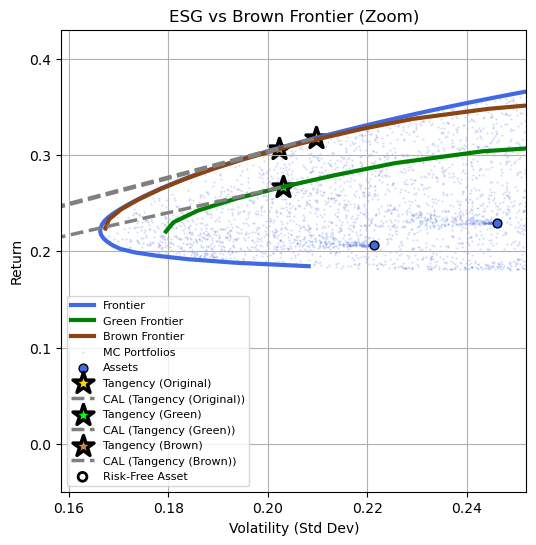

In [35]:
# -------------------------
# Zoom around tangency + small slice of frontier
# -------------------------
margin = 0.03   # increase for larger zoom, decrease for tighter zoom
pad_ratio = 0.25  # controls how much padding around the min/max

# --- slice around tangency ---
mask_blue  = (frontier_df["stdev"] >= tan_vol - margin) & (frontier_df["stdev"] <= tan_vol + margin)
mask_green = (frontier_esg_df["stdev"] >= tan_vol_esg - margin) & (frontier_esg_df["stdev"] <= tan_vol_esg + margin)
mask_brown = (frontier_brown_df["stdev"] >= tan_vol_b - margin) & (frontier_brown_df["stdev"] <= tan_vol_b + margin)

x_min = min(
    frontier_df.loc[mask_blue, "stdev"].min(),
    frontier_esg_df.loc[mask_green, "stdev"].min(),
    frontier_brown_df.loc[mask_brown, "stdev"].min(),
    tan_vol, tan_vol_esg, tan_vol_b
)

x_max = max(
    frontier_df.loc[mask_blue, "stdev"].max(),
    frontier_esg_df.loc[mask_green, "stdev"].max(),
    frontier_brown_df.loc[mask_brown, "stdev"].max(),
    tan_vol, tan_vol_esg, tan_vol_b
)

y_min = min(
    frontier_df.loc[mask_blue, "achieved_return"].min(),
    frontier_esg_df.loc[mask_green, "achieved_return"].min(),
    frontier_brown_df.loc[mask_brown, "achieved_return"].min(),
    tan_ret, tan_ret_esg, tan_ret_b,
    rf
)

y_max = max(
    frontier_df.loc[mask_blue, "achieved_return"].max(),
    frontier_esg_df.loc[mask_green, "achieved_return"].max(),
    frontier_brown_df.loc[mask_brown, "achieved_return"].max(),
    tan_ret, tan_ret_esg, tan_ret_b
)

# Add padding
pad_x = (x_max - x_min) * pad_ratio
pad_y = (y_max - y_min) * pad_ratio

xlim_zoom = (x_min - pad_x, x_max + pad_x)
ylim_zoom = (y_min - pad_y, y_max + pad_y)


# -------------------------
# Plot
# -------------------------
plot_frontier(
    title="ESG vs Brown Frontier (Zoom)",
    filename="Portfolio_Frontier_ESG_Brown_Zoom.png",
    frontiers=[
        {"stdev": frontier_df["stdev"], "achieved_return": frontier_df["achieved_return"], "color":"royalblue", "label":"Frontier"},
        {"stdev": frontier_esg_df["stdev"], "achieved_return": frontier_esg_df["achieved_return"], "color":"green", "label":"Green Frontier"},
        {"stdev": frontier_brown_df["stdev"], "achieved_return": frontier_brown_df["achieved_return"], "color":"saddlebrown", "label":"Brown Frontier"}
    ],
    mc_df=port_df,
    asset_returns=asset_returns,
    asset_stdevs=asset_stdevs,
    rf=rf,
    tangencies=[
        {"vol": tan_vol, "ret": tan_ret, "color":"gold", "label":"Tangency (Original)"},
        {"vol": tan_vol_esg, "ret": tan_ret_esg, "color":"lime", "label":"Tangency (Green)"},
        {"vol": tan_vol_b, "ret": tan_ret_b, "color":"peru", "label":"Tangency (Brown)"}
    ],
    xlim=xlim_zoom,
    ylim=ylim_zoom
)


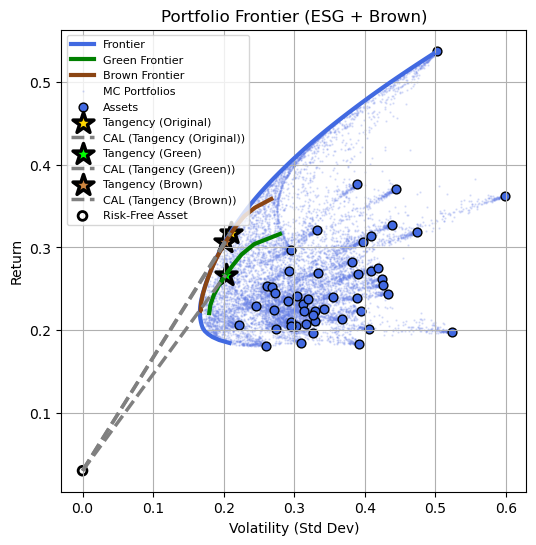

In [36]:
plot_frontier(
    title="Portfolio Frontier (ESG + Brown)",
    filename="Portfolio_Frontier_ESG_Brown.png",
    frontiers=[
        {"stdev": frontier_df["stdev"], "achieved_return": frontier_df["achieved_return"], "color":"royalblue", "label":"Frontier"},
        {"stdev": frontier_esg_df["stdev"], "achieved_return": frontier_esg_df["achieved_return"], "color":"green", "label":"Green Frontier"},
        {"stdev": frontier_brown_df["stdev"], "achieved_return": frontier_brown_df["achieved_return"], "color":"saddlebrown", "label":"Brown Frontier"}
    ],
    mc_df=port_df,
    asset_returns=asset_returns,
    asset_stdevs=asset_stdevs,
    rf=rf,
    tangencies=[
        {"vol": tan_vol, "ret": tan_ret, "color":"gold", "label":"Tangency (Original)"},
        {"vol": tan_vol_esg, "ret": tan_ret_esg, "color":"lime", "label":"Tangency (Green)"},
        {"vol": tan_vol_b, "ret": tan_ret_b, "color":"peru", "label":"Tangency (Brown)"}
    ]
)


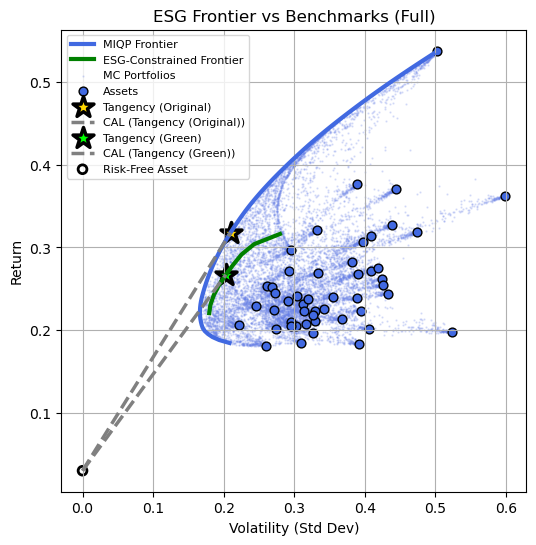

In [37]:
x_min = min(
    port_df["Volatility"].min(),
    frontier_df["stdev"].min(),
    frontier_esg_df["stdev"].min(),
    0  # <-- include risk-free x
)

x_max = max(
    port_df["Volatility"].max(),
    frontier_df["stdev"].max(),
    frontier_esg_df["stdev"].max()
)

y_min = min(
    port_df["Return"].min(),
    frontier_df["achieved_return"].min(),
    frontier_esg_df["achieved_return"].min(),
    rf  # <-- include risk-free y
)

y_max = max(
    port_df["Return"].max(),
    frontier_df["achieved_return"].max(),
    frontier_esg_df["achieved_return"].max()
)

pad_x = (x_max - x_min) * 0.05
pad_y = (y_max - y_min) * 0.05

xlim_full = (x_min - pad_x, x_max + pad_x)
ylim_full = (y_min - pad_y, y_max + pad_y)

plot_frontier(
    title="ESG Frontier vs Benchmarks (Full)",
    filename="ESG_Frontier_vs_Benchmarks_Full.png",
    frontiers=[
        {"stdev": frontier_df["stdev"], "achieved_return": frontier_df["achieved_return"], "color":"royalblue", "label":"MIQP Frontier"},
        {"stdev": frontier_esg_df["stdev"], "achieved_return": frontier_esg_df["achieved_return"], "color":"green", "label":"ESG-Constrained Frontier"}
    ],
    mc_df=port_df,
    asset_returns=asset_returns,
    asset_stdevs=asset_stdevs,
    rf=rf,
    tangencies=[
        {"vol": tan_vol, "ret": tan_ret, "color":"gold", "label":"Tangency (Original)"},
        {"vol": tan_vol_esg, "ret": tan_ret_esg, "color":"lime", "label":"Tangency (Green)"}
    ],
    xlim=xlim_full,
    ylim=ylim_full
)


In [38]:
def compute_metrics(returns, rf=0.00012):
    returns = pd.Series(returns).dropna()

    if len(returns) < 2:
        return {k: np.nan for k in [
            "annual_return","volatility","sharpe","sortino",
            "max_drawdown","calmar","cvar_95","rachev_95"
        ]}

    ann_factor = 252
    mean_ret = returns.mean() * ann_factor
    vol = returns.std(ddof=1) * np.sqrt(ann_factor)

    sharpe = (mean_ret - rf) / vol if vol != 0 else np.nan

    downside = returns[returns < 0]
    downside_std = downside.std(ddof=1) * np.sqrt(ann_factor)
    sortino = (mean_ret - rf) / downside_std if downside_std != 0 else np.nan

    # Max Drawdown
    cum = (1 + returns).cumprod()
    peak = cum.cummax()
    drawdown = (cum - peak) / peak
    max_dd = drawdown.min()
    calmar = mean_ret / abs(max_dd) if max_dd != 0 else np.nan

    # CVaR 95% and Rachev
    alpha = 0.05
    var = returns.quantile(alpha)
    cvar = returns[returns <= var].mean()
    ES = returns[returns <= var].sum()

    up_var = returns.quantile(1-alpha)
    cvar_up = returns[returns >= up_var].mean()

    rachev = cvar_up / abs(cvar) if cvar != 0 else np.nan

    return {
        "annual_return": mean_ret,
        "volatility": vol,
        "sharpe": sharpe,
        "sortino": sortino,
        "max_drawdown": max_dd,
        "calmar": calmar,
        "ES_95": ES,
        "rachev_95": rachev
    }


In [39]:
def portfolio_returns(weights, asset_returns_df):
    weights = np.array(weights).flatten()

    # asset_returns_df must be DataFrame with shape (n_days, n_assets)
    if asset_returns_df.shape[1] != len(weights):
        raise ValueError(
            f"Mismatch: asset_returns has {asset_returns_df.shape[1]} columns but weights length is {len(weights)}"
        )

    return asset_returns_df @ weights


In [40]:
ret_tan = portfolio_returns(tan_w, df_return_sel)
ret_tan_esg = portfolio_returns(tan_w_esg, df_return_sel)
ret_tan_brown = portfolio_returns(tan_w_b, df_return_sel)

metrics_tan = compute_metrics(ret_tan, rf=rf)
metrics_tan_esg = compute_metrics(ret_tan_esg, rf=rf)
metrics_tan_brown = compute_metrics(ret_tan_brown, rf=rf)

print(metrics_tan)
print(metrics_tan_esg)
print(metrics_tan_brown)


{'annual_return': 0.31790178981099504, 'volatility': 0.20973246915129423, 'sharpe': 1.3715653612197027, 'sortino': 1.7990146504204707, 'max_drawdown': -0.27073700122145455, 'calmar': 1.1742088756865603, 'ES_95': -3.6154274300954965, 'rachev_95': 1.0041151433379236}
{'annual_return': 0.26708781616578375, 'volatility': 0.20304793708435226, 'sharpe': 1.1664625583829005, 'sortino': 1.4530764427802112, 'max_drawdown': -0.3431337440580889, 'calmar': 0.7783781711674752, 'ES_95': -3.589437083532897, 'rachev_95': 0.9341225216350668}
{'annual_return': 0.306341445023802, 'volatility': 0.20231596429868334, 'sharpe': 1.3647041941593279, 'sortino': 1.759740353194901, 'max_drawdown': -0.27569343406772995, 'calmar': 1.111166996267828, 'ES_95': -3.522381417942085, 'rachev_95': 0.9796328151509356}


In [41]:
df_metrics = pd.DataFrame([
    {"Portfolio": "Tangency", **metrics_tan},
    {"Portfolio": "Tangency ESG", **metrics_tan_esg},
    {"Portfolio": "Tangency Brown", **metrics_tan_brown}
])

df_metrics.to_csv('TOPSIS/Performance_metrics.csv')
df_metrics


,Portfolio,annual_return,volatility,sharpe,sortino,max_drawdown,calmar,ES_95,rachev_95
0,Tangency,0.317902,0.209732,1.371565,1.799015,-0.270737,1.174209,-3.615427,1.004115
1,Tangency ESG,0.267088,0.203048,1.166463,1.453076,-0.343134,0.778378,-3.589437,0.934123
2,Tangency Brown,0.306341,0.202316,1.364704,1.759740,-0.275693,1.111167,-3.522381,0.979633
